## Created on Thr Aug 15 2024

## @author: Jeong-Woon, Park

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'CDH3'),
  Text(1, 0, 'ERBB2'),
  Text(2, 0, 'TYMS'),
  Text(3, 0, 'GREB1'),
  Text(4, 0, 'OSR1'),
  Text(5, 0, 'MYBL2'),
  Text(6, 0, 'FAM83D'),
  Text(7, 0, 'ESR1'),
  Text(8, 0, 'FOXC1'),
  Text(9, 0, 'NAT1')])

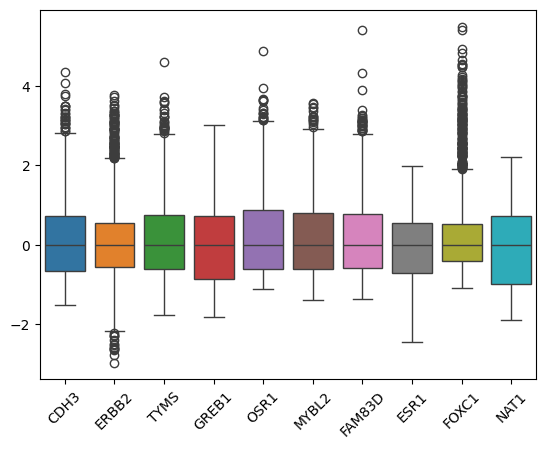

In [2]:
# Load X_train gene expression dataset.
X_train = pd.read_csv("X_train_feature_select.csv", sep = "\t", index_col = "Unnamed: 0")

# Feature distritubion after normalization (Train)
plt.rcdefaults()
sns.boxplot(X_train)
plt.xticks(rotation = 45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'CDH3'),
  Text(1, 0, 'ERBB2'),
  Text(2, 0, 'TYMS'),
  Text(3, 0, 'GREB1'),
  Text(4, 0, 'OSR1'),
  Text(5, 0, 'MYBL2'),
  Text(6, 0, 'FAM83D'),
  Text(7, 0, 'ESR1'),
  Text(8, 0, 'FOXC1'),
  Text(9, 0, 'NAT1')])

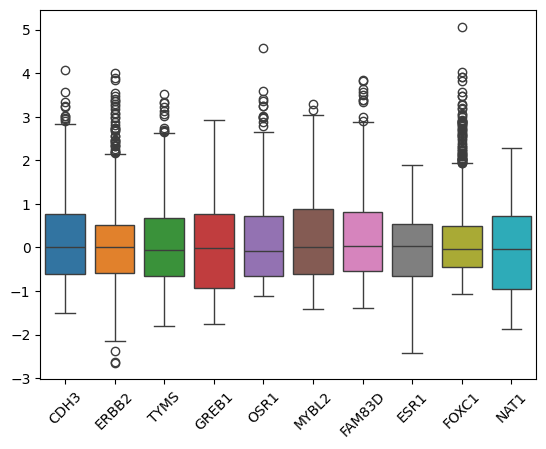

In [3]:
# Load X_test gene expression dataset.
X_test = pd.read_csv("X_test_feature_select.csv", sep = "\t", index_col = "Unnamed: 0")

# Feature distritubion after normalization (Test)
plt.rcdefaults()
sns.boxplot(X_test)
plt.xticks(rotation = 45)

In [4]:
# Load PAM50 subtype dataset.
target = pd.read_csv("GPL11154_PAM50.csv", sep = "\t", index_col = "geo_accession")
target.head()

,BRCA_Subtype_PAM50
geo_accession,
GSM2528079,Basal
GSM2528080,LumA
GSM2528081,LumB
GSM2528082,LumA
GSM2528084,Basal


In [5]:
# Load test PAM50 subtype dataset.
y_train = target.loc[X_train.index.tolist(), :]
y_train.head()

,BRCA_Subtype_PAM50
geo_accession,
GSM2528830,Her2
GSM2530511,LumA
GSM2529478,LumA
GSM2528452,LumA
GSM2531266,LumB


In [6]:
# Load test PAM50 subtype dataset.
y_test = target.loc[X_test.index.tolist(), :]
y_test.head()

,BRCA_Subtype_PAM50
geo_accession,
GSM2530931,LumB
GSM2528314,Basal
GSM2528222,Basal
GSM2531033,LumA
GSM2529552,LumB


In [7]:
# Label Encoder
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoder = encoder.transform(y_train)
y_test_encoder = encoder.transform(y_test)

# Create series.
y_train = pd.Series(y_train_encoder, index = y_train.index)
y_test = pd.Series(y_test_encoder, index = y_test.index)

In [8]:
# Downsampling based on k-means cluster,
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state = 42)
X_res, y_res = cc.fit_resample(X_train, y_train)

Text(0, 0.5, 'Frequency')

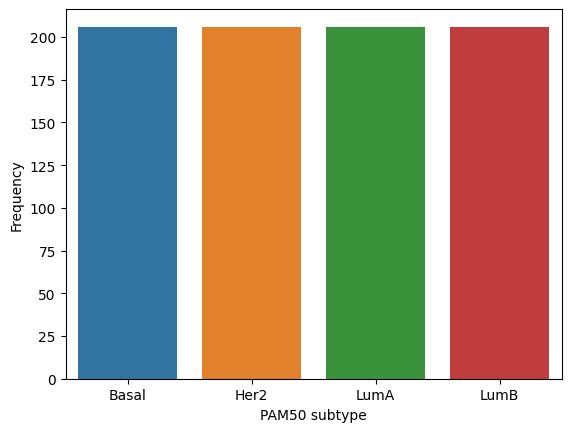

In [9]:
# Check count for each class in the training data.
class_counts = y_res.groupby(y_res).size()
class_counts.index = ["Basal", "Her2", "LumA", "LumB"]
sns.barplot(x = class_counts.index, y = class_counts.values, hue = class_counts.index)
plt.xlabel("PAM50 subtype")
plt.ylabel("Frequency")

### Compare model performance between original and undersampled data.

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, make_scorer, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_validate
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve
from imblearn.metrics import specificity_score, sensitivity_score

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10, random_state = 123)
clf = AdaBoostClassifier(random_state = 42)
specificity = make_scorer(specificity_score, average = 'macro')
sensitivity = make_scorer(sensitivity_score, average = 'macro')

scoring = {"accuracy" : "accuracy",
           "specificity" : specificity,
           "sensitivity" : sensitivity,
           "f1-score" : "f1_macro",
           "auc" : "roc_auc_ovr"}

origianl_score = cross_validate(clf, X_train, y_train, cv = cv, scoring = scoring, return_train_score = True)
undersample_score = cross_validate(clf, X_res, y_res, cv = cv, scoring = scoring, return_train_score = True)

In [11]:
print("Mean train accuracy (original) =", round(np.mean(origianl_score["train_accuracy"]), 3), "±", round(np.std(origianl_score["train_accuracy"]), 3))
print("Mean validation accuracy (original) =", round(np.mean(origianl_score["test_accuracy"]), 3), "±", round(np.std(origianl_score["test_accuracy"]), 3), "\n")
print("Mean train specificity (original) =", round(np.mean(origianl_score["train_specificity"]), 3), "±", round(np.std(origianl_score["train_specificity"]), 3))
print("Mean validation specificity (original) =", round(np.mean(origianl_score["test_specificity"]), 3), "±", round(np.std(origianl_score["test_specificity"]), 3), "\n")
print("Mean train sensitivity (original) =", round(np.mean(origianl_score["train_sensitivity"]), 3), "±", round(np.std(origianl_score["train_sensitivity"]), 3))
print("Mean validation sensitivity (original) =", round(np.mean(origianl_score["test_sensitivity"]), 3), "±", round(np.std(origianl_score["test_sensitivity"]), 3), "\n")
print("Mean train F1-score (original) =", round(np.mean(origianl_score["train_f1-score"]), 3), "±", round(np.std(origianl_score["train_f1-score"]), 3))
print("Mean validation F1-score (original) =", round(np.mean(origianl_score["test_f1-score"]), 3), "±", round(np.std(origianl_score["test_f1-score"]), 3), "\n")
print("Mean train AUROC (original) =", round(np.mean(origianl_score["train_auc"]), 3), "±", round(np.std(origianl_score["train_auc"]), 3))
print("Mean validation AUROC (original) =", round(np.mean(origianl_score["test_auc"]), 3), "±", round(np.std(origianl_score["test_auc"]), 3), "\n")

Mean train accuracy (original) = 0.865 ± 0.015
Mean validation accuracy (original) = 0.841 ± 0.026 

Mean train specificity (original) = 0.943 ± 0.007
Mean validation specificity (original) = 0.934 ± 0.012 

Mean train sensitivity (original) = 0.856 ± 0.014
Mean validation sensitivity (original) = 0.819 ± 0.03 

Mean train F1-score (original) = 0.861 ± 0.013
Mean validation F1-score (original) = 0.827 ± 0.028 

Mean train AUROC (original) = 0.934 ± 0.006
Mean validation AUROC (original) = 0.92 ± 0.011 



In [12]:
print("Mean train accuracy (undersampled) =", round(np.mean(undersample_score["train_accuracy"]), 3), "±", round(np.std(undersample_score["train_accuracy"]), 3))
print("Mean validation accuracy (undersampled) =", round(np.mean(undersample_score["test_accuracy"]), 3), "±", round(np.std(undersample_score["test_accuracy"]), 3), "\n")
print("Mean train specificity (undersampled) =", round(np.mean(undersample_score["train_specificity"]), 3), "±", round(np.std(undersample_score["train_specificity"]), 3))
print("Mean validation specificity (undersampled) =", round(np.mean(undersample_score["test_specificity"]), 3), "±", round(np.std(undersample_score["test_specificity"]), 3), "\n")
print("Mean train sensitivity (undersampled) =", round(np.mean(undersample_score["train_sensitivity"]), 3), "±", round(np.std(undersample_score["train_sensitivity"]), 3))
print("Mean validation sensitivity (undersampled) =", round(np.mean(undersample_score["test_sensitivity"]), 3), "±", round(np.std(undersample_score["test_sensitivity"]), 3), "\n")
print("Mean train F1-score (undersampled) =", round(np.mean(undersample_score["train_f1-score"]), 3), "±", round(np.std(undersample_score["train_f1-score"]), 3))
print("Mean validation F1-score (undersampled) =", round(np.mean(undersample_score["test_f1-score"]), 3), "±", round(np.std(undersample_score["test_f1-score"]), 3), "\n")
print("Mean train AUROC (undersampled) =", round(np.mean(undersample_score["train_auc"]), 3), "±", round(np.std(undersample_score["train_auc"]), 3))
print("Mean validation AUROC (undersampled) =", round(np.mean(undersample_score["test_auc"]), 3), "±", round(np.std(undersample_score["test_auc"]), 3), "\n")

Mean train accuracy (undersampled) = 0.86 ± 0.015
Mean validation accuracy (undersampled) = 0.814 ± 0.049 

Mean train specificity (undersampled) = 0.953 ± 0.005
Mean validation specificity (undersampled) = 0.938 ± 0.016 

Mean train sensitivity (undersampled) = 0.86 ± 0.015
Mean validation sensitivity (undersampled) = 0.814 ± 0.049 

Mean train F1-score (undersampled) = 0.861 ± 0.015
Mean validation F1-score (undersampled) = 0.815 ± 0.048 

Mean train AUROC (undersampled) = 0.957 ± 0.008
Mean validation AUROC (undersampled) = 0.938 ± 0.019 



###  Hyperparameter tuning using GridSearchCV

In [13]:
hyperparameters = {'n_estimators' : list(range(5, 51, 5)),
                   'learning_rate' : [1, 0.1, 0.01, 0.001],
                   'algorithm' : ['SAMME']}

optimizer = GridSearchCV(clf, hyperparameters, cv = cv, scoring = scoring, 
                         n_jobs = -1, return_train_score = True, refit = "accuracy")
best_model = optimizer.fit(X_train, y_train)

In [14]:
print('가장 좋은 n_estimator:', best_model.best_estimator_.get_params()['n_estimators'])
print('가장 좋은 learning rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('가장 좋은 algorithm:', best_model.best_estimator_.get_params()['algorithm'])
print("가장 좋은 Score :", round(best_model.best_score_, 3))

가장 좋은 n_estimator: 50
가장 좋은 learning rate: 1
가장 좋은 algorithm: SAMME
가장 좋은 Score : 0.843


In [15]:
# 데이터 값 실수. 소수점 셋째 자리까지 표시
pd.options.display.float_format = '{:.3f}'.format

# Make GridSearCV result.
CV_result = pd.DataFrame(best_model.cv_results_)
select_columns = ['params',
                  'mean_train_accuracy', 'std_train_accuracy', 'mean_test_accuracy', 'std_test_accuracy',
                  'mean_train_specificity', 'std_train_specificity', 'mean_test_specificity', 'std_test_specificity',
                  'mean_train_sensitivity', 'std_train_sensitivity', 'mean_test_sensitivity', 'std_test_sensitivity',
                  'mean_train_f1-score', 'std_train_f1-score', 'mean_test_f1-score', 'std_test_f1-score',
                  'mean_train_auc', 'std_train_auc', 'mean_test_auc', 'std_test_auc']

Final_GRID_result = CV_result.loc[:, select_columns].sort_values(by = 'mean_test_accuracy', ascending = False).reset_index(drop = True).transpose()
Final_GRID_result

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
params,"{'algorithm': 'SAMME', 'learning_rate': 1, 'n_...","{'algorithm': 'SAMME', 'learning_rate': 1, 'n_...","{'algorithm': 'SAMME', 'learning_rate': 1, 'n_...","{'algorithm': 'SAMME', 'learning_rate': 1, 'n_...","{'algorithm': 'SAMME', 'learning_rate': 1, 'n_...","{'algorithm': 'SAMME', 'learning_rate': 1, 'n_...","{'algorithm': 'SAMME', 'learning_rate': 1, 'n_...","{'algorithm': 'SAMME', 'learning_rate': 1, 'n_...","{'algorithm': 'SAMME', 'learning_rate': 1, 'n_...","{'algorithm': 'SAMME', 'learning_rate': 1, 'n_...",...,"{'algorithm': 'SAMME', 'learning_rate': 0.001,...","{'algorithm': 'SAMME', 'learning_rate': 0.001,...","{'algorithm': 'SAMME', 'learning_rate': 0.01, ...","{'algorithm': 'SAMME', 'learning_rate': 0.001,...","{'algorithm': 'SAMME', 'learning_rate': 0.001,...","{'algorithm': 'SAMME', 'learning_rate': 0.001,...","{'algorithm': 'SAMME', 'learning_rate': 0.001,...","{'algorithm': 'SAMME', 'learning_rate': 0.001,...","{'algorithm': 'SAMME', 'learning_rate': 0.001,...","{'algorithm': 'SAMME', 'learning_rate': 0.001,..."
mean_train_accuracy,0.864,0.860,0.855,0.849,0.842,0.834,0.821,0.804,0.769,0.701,...,0.635,0.634,0.634,0.634,0.634,0.633,0.633,0.633,0.632,0.631
std_train_accuracy,0.008,0.008,0.008,0.009,0.009,0.011,0.010,0.013,0.020,0.036,...,0.003,0.003,0.003,0.003,0.004,0.004,0.004,0.005,0.005,0.005
mean_test_accuracy,0.843,0.840,0.835,0.833,0.826,0.819,0.806,0.791,0.758,0.692,...,0.629,0.628,0.628,0.626,0.624,0.622,0.622,0.621,0.620,0.619
std_test_accuracy,0.025,0.024,0.027,0.025,0.027,0.027,0.029,0.027,0.032,0.042,...,0.016,0.017,0.017,0.019,0.019,0.019,0.019,0.019,0.019,0.019
mean_train_specificity,0.944,0.942,0.939,0.936,0.934,0.929,0.923,0.915,0.899,0.880,...,0.826,0.827,0.827,0.828,0.829,0.831,0.831,0.833,0.833,0.836
std_train_specificity,0.005,0.004,0.004,0.005,0.005,0.006,0.006,0.007,0.010,0.012,...,0.010,0.011,0.011,0.011,0.012,0.013,0.013,0.014,0.014,0.014
mean_test_specificity,0.935,0.934,0.931,0.930,0.927,0.922,0.916,0.909,0.895,0.877,...,0.823,0.823,0.823,0.824,0.825,0.826,0.826,0.827,0.828,0.830
std_test_specificity,0.011,0.011,0.012,0.011,0.012,0.013,0.013,0.013,0.015,0.016,...,0.006,0.006,0.006,0.007,0.008,0.009,0.009,0.010,0.010,0.012
mean_train_sensitivity,0.846,0.840,0.832,0.824,0.816,0.804,0.787,0.766,0.716,0.589,...,0.463,0.461,0.461,0.457,0.452,0.446,0.444,0.439,0.437,0.427


### Model evaluation using hyperparameter

In [16]:
# Model fitting and prediction.
model = best_model.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [17]:
# Classification report
print(classification_report(y_test, y_pred, target_names = ["Basal", "Her2", "LumA", "LumB"]))

              precision    recall  f1-score   support

       Basal       0.94      0.84      0.89        92
        Her2       0.85      0.75      0.80        89
        LumA       0.86      0.91      0.89       450
        LumB       0.74      0.71      0.72       200

    accuracy                           0.84       831
   macro avg       0.85      0.80      0.82       831
weighted avg       0.84      0.84      0.84       831



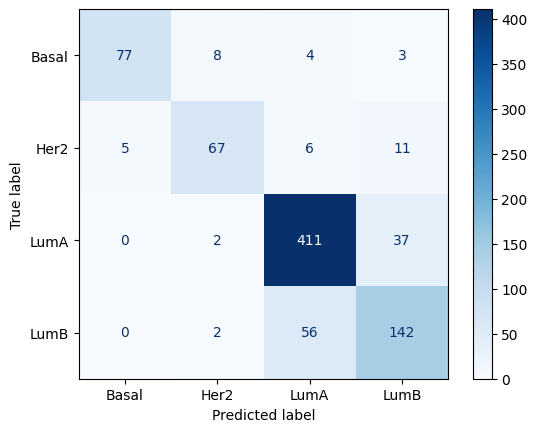

In [18]:
# Confusion matrix
plt.rcdefaults()
display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                                display_labels = ["Basal", "Her2", "LumA", "LumB"],
                                                cmap = plt.cm.Blues)
plt.grid(False)
plt.show()

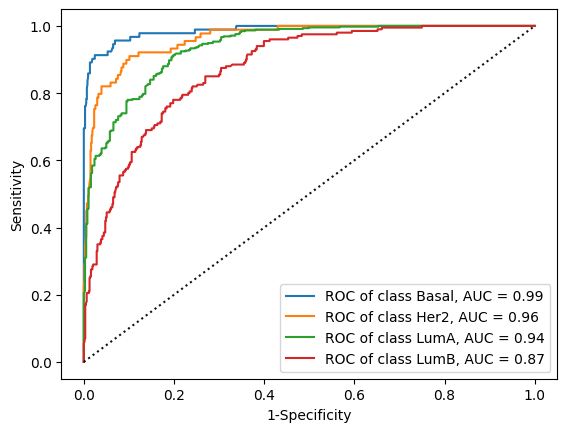

In [19]:
# ROC curve
plt.rcdefaults()
visualizer = ROCAUC(model, classes = ["Basal", "Her2", "LumA", "LumB"], macro = False, micro = False, title = " ")

visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)
visualizer.ax.set_xlabel("1-Specificity")
visualizer.ax.set_ylabel("Sensitivity")
visualizer.ax.legend(loc='best')
plt.show()

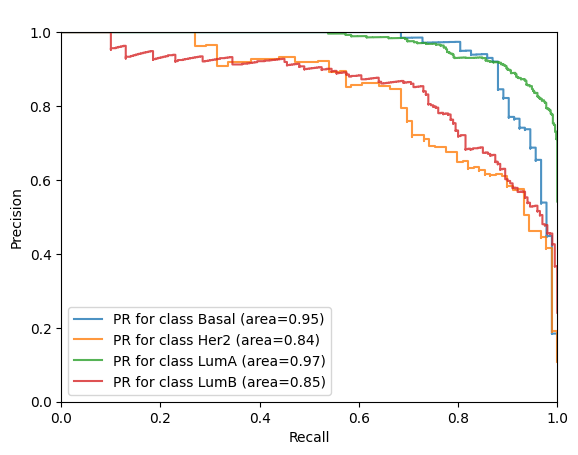

<Axes: title={'center': ' '}, xlabel='Recall', ylabel='Precision'>

In [20]:
# Precision-Recall curve
plt.rcdefaults()
visualizer = PrecisionRecallCurve(model, per_class = True, classes = ["Basal", "Her2", "LumA", "LumB"], 
                                  title = " ", ap_score = False)
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)       
visualizer.show()

In [21]:
# Accuracy
round(accuracy_score(y_test, y_pred), 3)

0.839

In [22]:
# Macro average specificity
round(specificity_score(y_test, y_pred, average = "macro"), 3)

0.931

In [23]:
# Macro average sensitivity
round(sensitivity_score(y_test, y_pred, average = "macro"), 3)

0.803

In [24]:
# Macro average F1 score
round(f1_score(y_test, y_pred, average = "macro"), 3)

0.823

In [25]:
# Macro average AUROC
round(roc_auc_score(y_test, y_pred_proba, multi_class = "ovr", average = "macro"), 3)

0.94